# Tutorial 3: Slide-seqV2 mouse olfactory bulb

This tutorial demonstrates how to identify spatial domains on Slide-seqV2 data.

In this tutorial, we foucs on the Slide-seqV2 mouse olfactory bulb data (Puck_200127_15 from https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2#study-summary).

We removed spots outside the main tissue area, and the used spots can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
input_dir = 'Data'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')

In [5]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col=0)
print(counts.shape, coor_df.shape)

(21220, 21724) (21724, 2)


In [6]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(-289.81710000000004, 6312.7151, 173.30850000000004, 5709.8615)

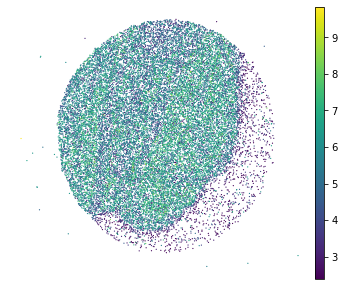

In [9]:
plt.rcParams["figure.figsize"] = (6,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=6, show=False)
plt.title('')
plt.axis('off')

In [ ]:
# can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing
used_barcode = pd.read_csv('Data/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]

NameError: name 'pd' is not defined

In [11]:
adata = adata[used_barcode,]

(588.545, 5108.555, 847.6700000000001, 5670.73)

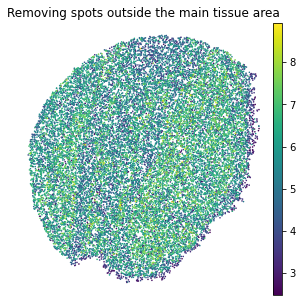

In [12]:
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=10, show=False, title='Removing spots outside the main tissue area')

plt.axis('off')

In [13]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (20139, 11750)


In [14]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 228288 edges, 20139 cells.
11.3356 neighbors per cell on average.


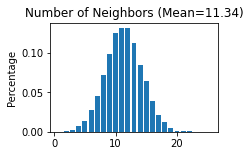

In [15]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE

In [16]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (20139, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [14:09<00:00,  1.70s/it]


In [17]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [18]:
sc.tl.louvain(adata, resolution=0.5)

In [19]:
adata.obsm["spatial"] = adata.obsm["spatial"] * (-1)

(-5108.555, -588.545, -5670.73, -847.6700000000001)

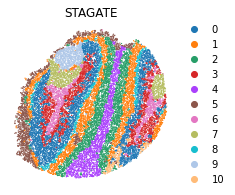

In [20]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

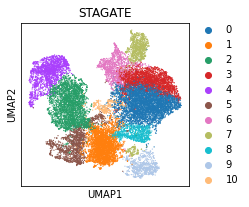

In [21]:
sc.pl.umap(adata, color='louvain', title='STAGATE')

## SCANPY results (for comparison)

In [22]:
sc.pp.pca(adata, n_comps=30)

In [23]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata)

(-5108.555, -588.545, -5670.73, -847.6700000000001)

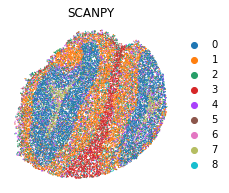

In [24]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='SCANPY')
plt.axis('off')

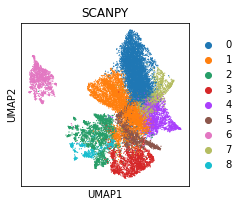

In [25]:
sc.pl.umap(adata, color='louvain', title='SCANPY')